In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sklearn
from sklearn import linear_model

In [2]:
# import scraped NBA stats from Excel file

xls = pd.ExcelFile('nba_draft.xlsx')

map = {}
for sheet_name in xls.sheet_names:
    map[sheet_name] = xls.parse(sheet_name)
    

In [3]:
new_frame = pd.DataFrame(columns=map['draft_data_2019'].columns)
del map['draft_data_2020']
# looping through each dataframe item in map, and only acquiring the rows for players who play Small Forward
for key, value in map.items():
    # collect statistics for cohort types - this is for Bigs
    test = value.loc[value['position'].str.contains('Center') | value['position'].str.contains('Power')]
    test = test[['Pk', 'college_G', 'college_TRB', 'college_TOV' ]]
    # reset indices and renumber
    test.reset_index(drop=True,inplace=True)
    test.index = test.index + 1
    test.Pk = test.index
    # drop any rows that are missing data
    test = test.dropna()
    if test.empty is False:
        new_frame = new_frame.append(test)

new_frame = new_frame[['Pk', 'college_G', 'college_TRB', 'college_TOV']]        

for column in new_frame:
    new_frame[column] = pd.to_numeric(new_frame[column])
    

X = new_frame.loc[:,new_frame.columns.str.startswith('college')]
y = new_frame['Pk'].astype(int)


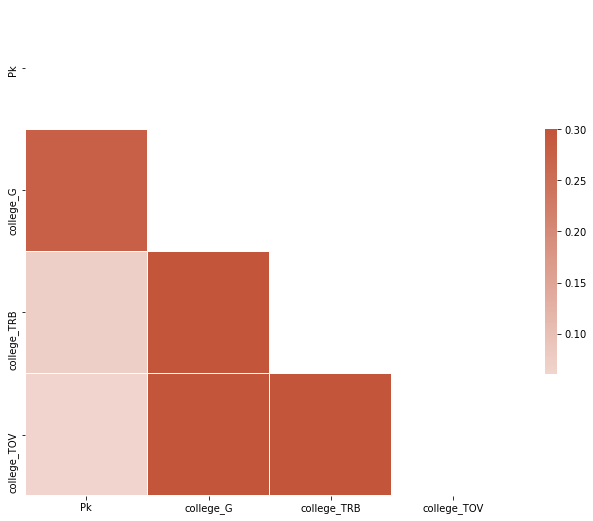

In [4]:
import seaborn as sns
# compute the correlation matrix for determining which traits to include in cohort specific analyses
corr = new_frame.corr()

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# format diverging colour palette for correlation matrix
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
# create an instance of the model
lin_reg_mod = linear_model.LinearRegression()
test_set_rmse = 0
test_set_r2 = 0
# number of splits/ folds
n = 10

kf = KFold(n_splits=n, shuffle=True, random_state=1)

# initialize variable for sum of correct prediction fractions
sum_of_c_fraction = 0
for train_index, test_index in kf.split(X):
    # initialize variable for counting number of correct predictions
    c = 0
    
    lin_reg_mod.fit(X.iloc[train_index],y.iloc[train_index])
    
    y_pred = lin_reg_mod.predict(X.iloc[test_index])
    
    # compare final prediction values against true values
    final_predictions = pd.DataFrame(columns = ['True Ranking','Predicted Ranking'])
    y_test = list(y.iloc[test_index])
    y_pred = list(y_pred)
    for i in range(0,len(y_test)):
        new_row = {'True Ranking': y_test[i],'Predicted Ranking': int(y_pred[i])}
        if y_test[i] == int(y_pred[i]):
            
            # increment c value if prediction is correct
            c = c + 1
        final_predictions = final_predictions.append(new_row, ignore_index=True)
        
    print(final_predictions)
    print(str(c/n))
    print(r2_score(y_test,y_pred))
    sum_of_c_fraction = sum_of_c_fraction + (c/len(y_test))
    # check the predictions against the actual values by using the root mean square deviation 
    # and coefficient of determination metrics
    test_set_rmse = test_set_rmse + (np.sqrt(mean_squared_error(y_test, y_pred)))
    test_set_r2 = test_set_r2 + r2_score(y_test, y_pred)

print('Average RMSE: ' + str(test_set_rmse/n))
print('Average R2: ' + str(test_set_r2/n))
print('Accuracy: ' + str((1/n)*int(sum_of_c_fraction)))

   True Ranking Predicted Ranking
0             5                12
1             8                12
2            11                11
3             5                11
4             2                 8
5             3                10
6             4                 9
7             7                 8
8            19                10
9            17                11
10            9                12
11            1                 7
12            2                10
13           17                14
14            2                10
15           19                11
16           22                13
17           15                14
18            1                 7
19            3                10
20            5                11
21            7                13
22            5                11
23            5                 8
24           10                10
25           12                10
26           13                11
27           22                14
28            

49            9                10
0.2
0.12133439308331162
   True Ranking Predicted Ranking
0             3                 8
1            11                10
2            21                13
3            13                 7
4            10                12
5            15                14
6            18                12
7            13                10
8            15                14
9            11                10
10           13                13
11            1                 7
12            7                11
13           17                10
14            3                 9
15            4                 7
16            6                 9
17            7                13
18           20                 8
19            7                 9
20           10                 8
21           18                10
22           20                11
23            6                 9
24           17                 8
25           18                14
26           14         

In [7]:
# dataframe showing all the features and their estimated coefficients obtained from the linear regression
coeff_df = pd.DataFrame(X.columns)
coeff_df.columns = ['Features']
coeff_df['Coefficient Estimate'] = pd.Series(lin_reg_mod.coef_)
coeff_df

,Features,Coefficient Estimate
0,college_G,0.115267
1,college_TRB,-0.008381
2,college_TOV,-0.006985
